#Libraries


In [1]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! pip install wandb

In [4]:
import wandb
from wandb.keras import WandbCallback
wandb.init(project="RNN-Kfold")

wandb: Currently logged in as: vinciwakanda (davinci). Use `wandb login --relogin` to force relogin


#Dataset


In [5]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Agrimonia/Recap previous thesis/Agrimonia_Dataset_v_2_0_1.csv")
pd.set_option('display.max_columns', None)
df['Latitude'] = df['Latitude'].round(2)
df['Longitude'] = df['Longitude'].round(2)

df['AQ_nh3'] = df['AQ_nh3'].replace('NaN', np.nan)
df.head()

<ipython-input-5-c496d5c7ae23>:1: DtypeWarning: Columns (0,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Agrimonia/Recap previous thesis/Agrimonia_Dataset_v_2_0_1.csv")


,IDStations,Latitude,Longitude,Time,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,AQ_no2,AQ_so2,WE_temp_2m,WE_wind_speed_10m_mean,WE_wind_speed_10m_max,WE_mode_wind_direction_10m,WE_tot_precipitation,WE_precipitation_t,WE_surface_pressure,WE_solar_radiation,WE_rh_min,WE_rh_mean,WE_rh_max,WE_wind_speed_100m_mean,WE_wind_speed_100m_max,WE_mode_wind_direction_100m,WE_blh_layer_max,WE_blh_layer_min,EM_nh3_livestock_mm,EM_nh3_agr_soils,EM_nh3_agr_waste_burn,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
0,1264,46.17,9.88,2016-01-01,290,6.200e+01,5.300e+01,NaN,NaN,8.263e+01,3.772e+01,NaN,-2.212,0.5970,0.9883,S,0.00037,0,83720.0,5664000.0,88.70,93.66,99.19,1.0730,1.977,S,340.6,10.63,2.015e-01,1.462e-01,2.019e-03,6.166e-01,8.359e-01,1.720e+00,3.906e-01,0.3832,5.892,3.998,1.234,112,17.0
1,1264,46.17,9.88,2016-01-02,290,7.300e+01,6.300e+01,NaN,NaN,1.017e+02,3.884e+01,NaN,-3.063,0.4402,0.7365,SE,0.07521,5,82990.0,1335000.0,94.07,97.60,99.24,1.0530,2.321,S,238.7,21.55,2.020e-01,1.589e-01,1.956e-03,6.298e-01,8.372e-01,1.720e+00,3.911e-01,0.3832,5.892,3.997,1.234,112,17.0
2,1264,46.17,9.88,2016-01-03,290,4.400e+01,3.900e+01,NaN,NaN,6.626e+01,3.234e+01,NaN,-2.768,0.6954,1.0100,S,0.02744,5,82320.0,3728000.0,90.15,95.73,98.55,1.9810,2.942,S,407.0,22.80,2.024e-01,1.708e-01,1.890e-03,6.424e-01,8.384e-01,1.720e+00,3.916e-01,0.3832,5.892,3.997,1.234,112,17.0
3,1264,46.17,9.88,2016-01-04,290,3.100e+01,2.900e+01,NaN,NaN,6.331e+01,3.167e+01,NaN,-4.352,0.5812,0.9421,W,0.08564,5,81410.0,1846000.0,90.84,96.01,99.43,1.2080,2.284,N,536.7,12.21,2.027e-01,1.821e-01,1.822e-03,6.545e-01,8.396e-01,1.720e+00,3.923e-01,0.3832,5.892,3.997,1.234,112,17.0
4,1264,46.17,9.88,2016-01-05,290,2.700e+01,2.600e+01,NaN,NaN,7.553e+01,3.333e+01,NaN,-6.184,0.5906,0.9847,SE,0.01802,5,81530.0,1733000.0,89.31,93.53,99.05,0.8226,1.672,SE,472.4,10.15,2.031e-01,1.929e-01,1.750e-03,6.660e-01,8.409e-01,1.720e+00,3.931e-01,0.3832,5.892,3.997,1.233,112,17.0


## Select the subset

In [6]:
df = df[df['IDStations']==1266]
df.head()

,IDStations,Latitude,Longitude,Time,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,AQ_no2,AQ_so2,WE_temp_2m,WE_wind_speed_10m_mean,WE_wind_speed_10m_max,WE_mode_wind_direction_10m,WE_tot_precipitation,WE_precipitation_t,WE_surface_pressure,WE_solar_radiation,WE_rh_min,WE_rh_mean,WE_rh_max,WE_wind_speed_100m_mean,WE_wind_speed_100m_max,WE_mode_wind_direction_100m,WE_blh_layer_max,WE_blh_layer_min,EM_nh3_livestock_mm,EM_nh3_agr_soils,EM_nh3_agr_waste_burn,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
4384,1266,45.23,9.67,2016-01-01,65,5.200e+01,NaN,NaN,3.220e+01,3.621e+01,2.350e+01,NaN,2.1610,0.9449,1.818,E,0.000009,0,101900.0,5330000.0,92.17,97.16,99.67,1.429,2.622,NE,351.7,13.88,8.907e+00,3.187e-01,1.439e-01,9.749e+00,1.922e+00,3.844e+00,9.099e-01,513.5,255.2,1.548,2.084,112,17.0
4385,1266,45.23,9.67,2016-01-02,65,3.900e+01,NaN,NaN,1.460e+01,2.972e+01,2.475e+01,NaN,0.9301,1.4660,2.335,E,0.102000,1,101100.0,782500.0,97.69,99.12,99.88,2.693,4.317,E,263.3,42.82,8.927e+00,3.462e-01,1.395e-01,9.792e+00,1.925e+00,3.832e+00,9.082e-01,514.0,255.1,1.548,2.084,112,17.0
4386,1266,45.23,9.67,2016-01-03,65,2.600e+01,NaN,NaN,1.120e+01,2.827e+01,2.415e+01,NaN,2.2690,2.0650,3.364,E,0.053580,1,100200.0,3285000.0,96.03,98.46,99.89,3.978,6.581,E,355.5,98.28,8.944e+00,3.722e-01,1.348e-01,9.832e+00,1.928e+00,3.821e+00,9.067e-01,514.5,255.1,1.548,2.084,112,17.0
4387,1266,45.23,9.67,2016-01-04,65,2.900e+01,NaN,NaN,1.080e+01,2.462e+01,1.971e+01,NaN,1.8980,1.3000,3.356,E,0.075220,1,99250.0,1760000.0,96.12,98.12,99.81,2.657,6.460,E,345.6,21.80,8.961e+00,3.969e-01,1.299e-01,9.869e+00,1.931e+00,3.809e+00,9.054e-01,515.0,255.0,1.548,2.083,112,17.0
4388,1266,45.23,9.67,2016-01-05,65,3.400e+01,NaN,NaN,1.510e+01,3.484e+01,2.293e+01,NaN,1.5550,1.0270,1.708,E,0.012900,1,99310.0,1429000.0,97.10,99.06,99.84,2.079,3.423,E,231.6,24.76,8.976e+00,4.204e-01,1.248e-01,9.903e+00,1.933e+00,3.797e+00,9.042e-01,515.5,254.9,1.548,2.083,112,17.0


In [7]:
df = df.drop(['AQ_so2', 'AQ_pm25', 'AQ_co'], axis=1)
df.head()

,IDStations,Latitude,Longitude,Time,Altitude,AQ_pm10,AQ_nh3,AQ_nox,AQ_no2,WE_temp_2m,WE_wind_speed_10m_mean,WE_wind_speed_10m_max,WE_mode_wind_direction_10m,WE_tot_precipitation,WE_precipitation_t,WE_surface_pressure,WE_solar_radiation,WE_rh_min,WE_rh_mean,WE_rh_max,WE_wind_speed_100m_mean,WE_wind_speed_100m_max,WE_mode_wind_direction_100m,WE_blh_layer_max,WE_blh_layer_min,EM_nh3_livestock_mm,EM_nh3_agr_soils,EM_nh3_agr_waste_burn,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
4384,1266,45.23,9.67,2016-01-01,65,5.200e+01,3.220e+01,3.621e+01,2.350e+01,2.1610,0.9449,1.818,E,0.000009,0,101900.0,5330000.0,92.17,97.16,99.67,1.429,2.622,NE,351.7,13.88,8.907e+00,3.187e-01,1.439e-01,9.749e+00,1.922e+00,3.844e+00,9.099e-01,513.5,255.2,1.548,2.084,112,17.0
4385,1266,45.23,9.67,2016-01-02,65,3.900e+01,1.460e+01,2.972e+01,2.475e+01,0.9301,1.4660,2.335,E,0.102000,1,101100.0,782500.0,97.69,99.12,99.88,2.693,4.317,E,263.3,42.82,8.927e+00,3.462e-01,1.395e-01,9.792e+00,1.925e+00,3.832e+00,9.082e-01,514.0,255.1,1.548,2.084,112,17.0
4386,1266,45.23,9.67,2016-01-03,65,2.600e+01,1.120e+01,2.827e+01,2.415e+01,2.2690,2.0650,3.364,E,0.053580,1,100200.0,3285000.0,96.03,98.46,99.89,3.978,6.581,E,355.5,98.28,8.944e+00,3.722e-01,1.348e-01,9.832e+00,1.928e+00,3.821e+00,9.067e-01,514.5,255.1,1.548,2.084,112,17.0
4387,1266,45.23,9.67,2016-01-04,65,2.900e+01,1.080e+01,2.462e+01,1.971e+01,1.8980,1.3000,3.356,E,0.075220,1,99250.0,1760000.0,96.12,98.12,99.81,2.657,6.460,E,345.6,21.80,8.961e+00,3.969e-01,1.299e-01,9.869e+00,1.931e+00,3.809e+00,9.054e-01,515.0,255.0,1.548,2.083,112,17.0
4388,1266,45.23,9.67,2016-01-05,65,3.400e+01,1.510e+01,3.484e+01,2.293e+01,1.5550,1.0270,1.708,E,0.012900,1,99310.0,1429000.0,97.10,99.06,99.84,2.079,3.423,E,231.6,24.76,8.976e+00,4.204e-01,1.248e-01,9.903e+00,1.933e+00,3.797e+00,9.042e-01,515.5,254.9,1.548,2.083,112,17.0


In [8]:
print(df.dtypes)


IDStations                      object
Latitude                       float64
Longitude                      float64
Time                            object
Altitude                         int64
AQ_pm10                         object
AQ_nh3                          object
AQ_nox                          object
AQ_no2                          object
WE_temp_2m                     float64
WE_wind_speed_10m_mean         float64
WE_wind_speed_10m_max          float64
WE_mode_wind_direction_10m      object
WE_tot_precipitation           float64
WE_precipitation_t               int64
WE_surface_pressure            float64
WE_solar_radiation             float64
WE_rh_min                      float64
WE_rh_mean                     float64
WE_rh_max                      float64
WE_wind_speed_100m_mean        float64
WE_wind_speed_100m_max         float64
WE_mode_wind_direction_100m     object
WE_blh_layer_max               float64
WE_blh_layer_min               float64
EM_nh3_livestock_mm      

In [9]:
#df['IDStations'] = df['IDStations'].astype(float)
df['AQ_pm10'] = df['AQ_pm10'].astype(float)
df['AQ_nh3'] = df['AQ_nh3'].astype(float)
df['AQ_nox'] = df['AQ_nox'].astype(float)
df['AQ_no2'] = df['AQ_no2'].astype(float)

df['EM_nh3_livestock_mm'] = df['EM_nh3_livestock_mm'].astype(float)
df['EM_nh3_agr_soils'] = df['EM_nh3_agr_soils'].astype(float)
df['EM_nh3_agr_waste_burn'] = df['EM_nh3_agr_waste_burn'].astype(float)
df['EM_nh3_sum'] = df['EM_nh3_sum'].astype(float)
df['EM_nox_traffic'] = df['EM_nox_traffic'].astype(float)
df['EM_nox_sum'] = df['EM_nox_sum'].astype(float)
df['EM_so2_sum'] = df['EM_so2_sum'].astype(float)
df['LI_pigs'] = df['LI_pigs'].astype(float)
df['LI_bovine'] = df['LI_bovine'].astype(float)

In [10]:
print(df.dtypes)


IDStations                      object
Latitude                       float64
Longitude                      float64
Time                            object
Altitude                         int64
AQ_pm10                        float64
AQ_nh3                         float64
AQ_nox                         float64
AQ_no2                         float64
WE_temp_2m                     float64
WE_wind_speed_10m_mean         float64
WE_wind_speed_10m_max          float64
WE_mode_wind_direction_10m      object
WE_tot_precipitation           float64
WE_precipitation_t               int64
WE_surface_pressure            float64
WE_solar_radiation             float64
WE_rh_min                      float64
WE_rh_mean                     float64
WE_rh_max                      float64
WE_wind_speed_100m_mean        float64
WE_wind_speed_100m_max         float64
WE_mode_wind_direction_100m     object
WE_blh_layer_max               float64
WE_blh_layer_min               float64
EM_nh3_livestock_mm      

In [11]:
print(df.isna().sum())

IDStations                       0
Latitude                         0
Longitude                        0
Time                             0
Altitude                         0
AQ_pm10                         65
AQ_nh3                         296
AQ_nox                          75
AQ_no2                          75
WE_temp_2m                       0
WE_wind_speed_10m_mean           0
WE_wind_speed_10m_max            0
WE_mode_wind_direction_10m       0
WE_tot_precipitation             0
WE_precipitation_t               0
WE_surface_pressure              0
WE_solar_radiation               0
WE_rh_min                        0
WE_rh_mean                       0
WE_rh_max                        0
WE_wind_speed_100m_mean          0
WE_wind_speed_100m_max           0
WE_mode_wind_direction_100m      0
WE_blh_layer_max                 0
WE_blh_layer_min                 0
EM_nh3_livestock_mm            365
EM_nh3_agr_soils               365
EM_nh3_agr_waste_burn          365
EM_nh3_sum          

In [12]:
df.dropna(inplace=True)
df

,IDStations,Latitude,Longitude,Time,Altitude,AQ_pm10,AQ_nh3,AQ_nox,AQ_no2,WE_temp_2m,WE_wind_speed_10m_mean,WE_wind_speed_10m_max,WE_mode_wind_direction_10m,WE_tot_precipitation,WE_precipitation_t,WE_surface_pressure,WE_solar_radiation,WE_rh_min,WE_rh_mean,WE_rh_max,WE_wind_speed_100m_mean,WE_wind_speed_100m_max,WE_mode_wind_direction_100m,WE_blh_layer_max,WE_blh_layer_min,EM_nh3_livestock_mm,EM_nh3_agr_soils,EM_nh3_agr_waste_burn,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
4384,1266,45.23,9.67,2016-01-01,65,52.0,32.2,36.21,23.50,2.1610,0.9449,1.818,E,0.000009,0,101900.0,5330000.0,92.17,97.16,99.67,1.429,2.622,NE,351.7,13.88,8.907,0.3187,0.1439,9.749,1.922,3.844,0.9099,513.5,255.2,1.548,2.084,112,17.0
4385,1266,45.23,9.67,2016-01-02,65,39.0,14.6,29.72,24.75,0.9301,1.4660,2.335,E,0.102000,1,101100.0,782500.0,97.69,99.12,99.88,2.693,4.317,E,263.3,42.82,8.927,0.3462,0.1395,9.792,1.925,3.832,0.9082,514.0,255.1,1.548,2.084,112,17.0
4386,1266,45.23,9.67,2016-01-03,65,26.0,11.2,28.27,24.15,2.2690,2.0650,3.364,E,0.053580,1,100200.0,3285000.0,96.03,98.46,99.89,3.978,6.581,E,355.5,98.28,8.944,0.3722,0.1348,9.832,1.928,3.821,0.9067,514.5,255.1,1.548,2.084,112,17.0
4387,1266,45.23,9.67,2016-01-04,65,29.0,10.8,24.62,19.71,1.8980,1.3000,3.356,E,0.075220,1,99250.0,1760000.0,96.12,98.12,99.81,2.657,6.460,E,345.6,21.80,8.961,0.3969,0.1299,9.869,1.931,3.809,0.9054,515.0,255.0,1.548,2.083,112,17.0
4388,1266,45.23,9.67,2016-01-05,65,34.0,15.1,34.84,22.93,1.5550,1.0270,1.708,E,0.012900,1,99310.0,1429000.0,97.10,99.06,99.84,2.079,3.423,E,231.6,24.76,8.976,0.4204,0.1248,9.903,1.933,3.797,0.9042,515.5,254.9,1.548,2.083,112,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5840,1266,45.23,9.67,2019-12-27,65,50.0,42.8,96.50,34.48,4.1010,0.8183,1.877,NW,0.001527,0,101600.0,4225000.0,92.92,96.34,98.53,1.502,3.233,W,254.7,11.51,9.002,0.7423,0.1610,10.470,1.106,2.881,0.8955,521.4,253.9,1.548,2.085,112,17.0
5841,1266,45.23,9.67,2019-12-28,65,62.0,40.7,105.50,34.10,3.3690,1.4380,2.083,E,0.000138,0,102400.0,3343000.0,94.78,97.82,99.95,2.336,4.549,E,271.1,16.37,8.971,0.6313,0.1577,10.320,1.097,2.860,0.8926,521.4,253.9,1.548,2.085,112,17.0
5842,1266,45.23,9.67,2019-12-29,65,65.0,38.7,77.59,28.73,2.6440,1.0990,2.978,E,0.000275,1,102700.0,4482000.0,94.17,97.99,99.75,2.017,5.354,E,347.0,14.37,8.943,0.5322,0.1543,10.190,1.089,2.841,0.8899,521.4,253.9,1.548,2.084,112,17.0
5843,1266,45.23,9.67,2019-12-30,65,48.0,20.6,32.91,19.10,1.7840,1.3020,2.857,E,0.000097,0,102900.0,3991000.0,94.72,98.13,99.76,1.869,4.482,W,352.4,17.79,8.917,0.4461,0.1508,10.070,1.082,2.823,0.8875,521.4,253.9,1.548,2.084,112,17.0


In [13]:
print(df.isna().sum())

IDStations                     0
Latitude                       0
Longitude                      0
Time                           0
Altitude                       0
AQ_pm10                        0
AQ_nh3                         0
AQ_nox                         0
AQ_no2                         0
WE_temp_2m                     0
WE_wind_speed_10m_mean         0
WE_wind_speed_10m_max          0
WE_mode_wind_direction_10m     0
WE_tot_precipitation           0
WE_precipitation_t             0
WE_surface_pressure            0
WE_solar_radiation             0
WE_rh_min                      0
WE_rh_mean                     0
WE_rh_max                      0
WE_wind_speed_100m_mean        0
WE_wind_speed_100m_max         0
WE_mode_wind_direction_100m    0
WE_blh_layer_max               0
WE_blh_layer_min               0
EM_nh3_livestock_mm            0
EM_nh3_agr_soils               0
EM_nh3_agr_waste_burn          0
EM_nh3_sum                     0
EM_nox_traffic                 0
EM_nox_sum

#Linear regression

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


8/8 [==============================] - 0s 6ms/step
iteration1


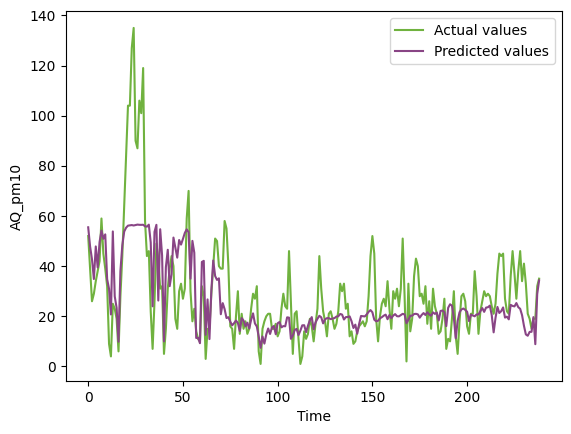

8/8 [==============================] - 0s 3ms/step

8/8 [==============================] - 0s 5ms/step
iteration2


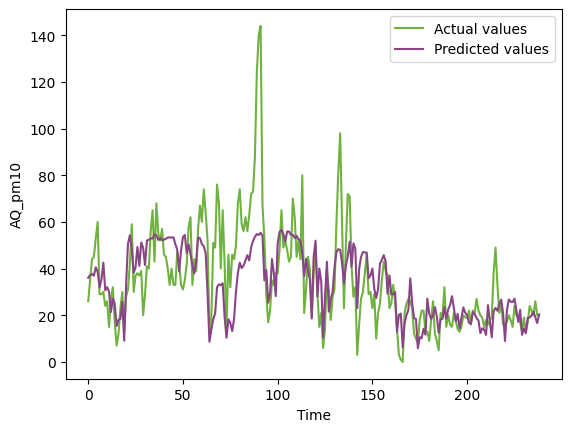

8/8 [==============================] - 0s 3ms/step

8/8 [==============================] - 0s 4ms/step
iteration3


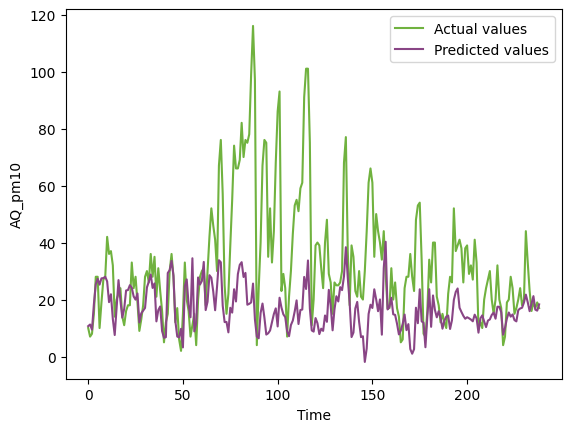

8/8 [==============================] - 0s 3ms/step

8/8 [==============================] - 0s 4ms/step
iteration4


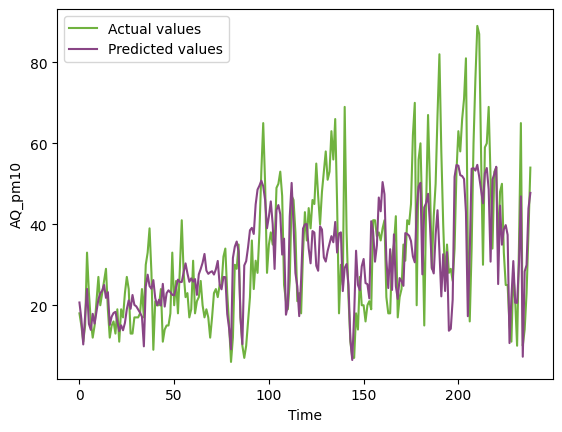

8/8 [==============================] - 0s 4ms/step

8/8 [==============================] - 0s 5ms/step
iteration5


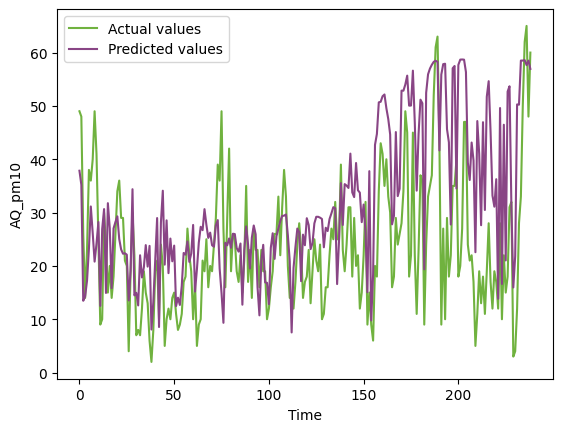

8/8 [==============================] - 0s 4ms/step



In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional
from sklearn.preprocessing import StandardScaler

# Select independent and dependent variables
X = df[['Latitude', 'Longitude', 'Altitude', 'WE_temp_2m', 'WE_wind_speed_10m_mean', 'WE_wind_speed_10m_max', 'WE_tot_precipitation', 'WE_precipitation_t', 'WE_surface_pressure', 'WE_solar_radiation', 'WE_rh_min', 'WE_rh_mean', 'WE_rh_max', 'WE_wind_speed_100m_max', 'WE_blh_layer_max', 'WE_blh_layer_min', 'EM_nh3_livestock_mm', 'EM_nh3_agr_soils', 'EM_nh3_agr_waste_burn', 'EM_nh3_sum', 'EM_nox_traffic', 'EM_nox_sum', 'EM_so2_sum', 'LI_pigs', 'LI_bovine', 'LA_hvi', 'LA_lvi', 'LA_land_use', 'LA_soil_use']]
y = df[['AQ_pm10']]

# Define number of folds
# no shuffle
n_splits = 5

# Create an instance of KFold
kf = KFold(n_splits=n_splits)

# Create lists to store results
r2_train_list = []
rmse_train_list = []
mae_train_list = []
var_train_list = []
r2_test_list = []
rmse_test_list = []
mae_test_list = []
var_test_list = []

k = 1
# Loop over the splits
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the input data for the GRU layer
    X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Create and compile the neural network model
    model = keras.Sequential([
        GRU(32, input_shape=(1, X_train_scaled.shape[1])),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model on the training data
    model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=0, callbacks=[WandbCallback()])

    # Make a prediction on the training data and calculate metrics
    y_train_pred = model.predict(X_train_reshaped)
    r2_train = r2_score(y_train, y_train_pred)
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    var_train = np.var(y_train - y_train_pred)

    # Make a prediction on the testing data and calculate metrics
    y_test_pred = model.predict(X_test_reshaped)
    r2_test = r2_score(y_test, y_test_pred)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    var_test = np.var(y_test - y_test_pred)

    # Add results to lists
    r2_train_list.append(r2_train)
    rmse_train_list.append(rmse_train)
    mae_train_list.append(mae_train)
    var_train_list.append(var_train)
    r2_test_list.append(r2_test)
    rmse_test_list.append(rmse_test)
    mae_test_list.append(mae_test)
    var_test_list.append(var_test)

    wandb.log({"Training set R2":  r2_train})
    wandb.log({"Training set rmse":  rmse_train})
    wandb.log({"Training set mae":  mae_train})
    wandb.log({"Testing set R2": r2_test})
    wandb.log({"Testing set rmse": rmse_test})
    wandb.log({"Testing set mae": mae_test})

    print("iteration" + str(k))
    # Plot the actual values in blue
    plt.plot(y_test.values, color='xkcd:nasty green', label='Actual values')

    # Plot the predicted values in red
    plt.plot(y_test_pred, color='xkcd:light eggplant', label='Predicted values')

    # Add legend and labels
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('AQ_pm10')

    # Show the plot
    plt.show()

    # Calculate predictions for training and testing data
    y_train_pred = model.predict(X_train_reshaped)
    y_test_pred = model.predict(X_test_reshaped)

    # Disegna il grafico
    plt.scatter(y_train, y_train_pred, color='xkcd:nasty green', label='Training set')
    plt.scatter(y_test, y_test_pred, color='xkcd:light eggplant', label='Test set')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.legend(loc='lower right')
    # Save the plot to a BytesIO object

    plot_buffer = io.BytesIO()
    plt.savefig(plot_buffer, format='png')
    plt.close()

    # Convert the BytesIO buffer to a PIL Image
    plot_pil_image = Image.open(plot_buffer)

    # Convert the PIL Image to a NumPy array
    plot_numpy_array = np.array(plot_pil_image)

    # Log the plot to Weights and Biases
    wandb.log({"scatter_plot": wandb.Image(plot_numpy_array)})

    # Display the plot (optional)
    plt.show()

    print()
    k += 1


In [15]:
# Calculate mean results over all splits
##Train
r2_train_mean = sum(r2_train_list) / n_splits
rmse_train_mean = sum(rmse_train_list) / n_splits
mae_train_mean = sum(mae_train_list) / n_splits
var_train_mean = sum(var_train_list)/ n_splits
##test
r2_test_mean = sum(r2_test_list) / n_splits
rmse_test_mean = sum(rmse_test_list) / n_splits
mae_test_mean = sum(mae_test_list) / n_splits
var_test_mean = sum(var_test_list)/ n_splits


##Train

In [16]:
print(r2_train_mean )
print(rmse_train_mean)
print(mae_train_mean)
print(var_train_mean)

0.62249500282837
11.885909234332122
7.866770249480483
AQ_pm10    140.970148
dtype: float64


## Test

In [17]:
print(r2_test_mean )
print(rmse_test_mean)
print(mae_test_mean)
print(var_test_mean)

0.08404784711401739
16.92570377887153
12.058729094740736
AQ_pm10    240.194722
dtype: float64
